In [194]:
# imports
import sys
print(sys.executable)
import numpy as np
import matplotlib.pyplot as plt
import emcee 
import corner
from time import time

C:\Users\ericl\Anaconda3\python.exe


## Task 1: Replicate figure 1

Replicate figure 1, using emcee to sample the parameter space for a flat prior and a naturaleness prior.

In [195]:
# Load dataset
def load_data(file):
    d = {
        "x": [],
        "d": [],
        "sigma": []
    }
    # Skip first two rows, which are the header:
    with open(file) as f:
        for idx,line in enumerate(f):
            if idx < 3:
                pass
            else:
                val = line.split()
                d["x"].append(np.float(val[0]))
                d["d"].append(np.float(val[1]))
                d["sigma"].append(np.float(val[2]))
    # cast to numpy arrays
    d["x"] = np.array(d["x"])
    d["d"] = np.array(d["d"])
    d["sigma"] = np.array(d["sigma"])
    return d


file = 'D1_c_5.dat'
data = load_data(file)
display(data)

{'x': array([0.03183, 0.06366, 0.09549, 0.12732, 0.15915, 0.19099, 0.22282,
        0.25465, 0.28648, 0.31831]),
 'd': array([0.31694, 0.33844, 0.42142, 0.57709, 0.56218, 0.68851, 0.73625,
        0.8727 , 1.0015 , 1.0684 ]),
 'sigma': array([0.01585 , 0.01692 , 0.02107 , 0.02885 , 0.02811 , 0.03443 ,
        0.03681 , 0.04364 , 0.050075, 0.05342 ])}

Define uniform prior and naturaleness prior. Naturaleness prior means that the constants $\{a_i\}$ are constrained to be of order one. The naturaleness prior is defined as:

$$ pr(a|\bar{a}, I) = \left( \frac{1}{\sqrt{2 \pi} \bar{a}} \right)^{len(a)} \exp\left({\frac{-a^2}{2 \bar{a}^2}}\right).$$

Note that $a$ is a vector, so $a^2 = a\cdot a$. The log of this prior is:

$$ \log{pr(a|\bar{a}, I)} = -len(a) \sqrt{2 \pi} \bar{a} - \frac{1}{2}\frac{a^2}{\bar{a}^2}$$

In [196]:
def log_uniform_prior(a):
    '''
    Uniform prior, returns a log(1) if the values in a are in abs(a)<100. Note that this
    prior is not normalized. We take care of this later.
    '''
    if np.all(np.abs(a)<=100):
        return 0  # log(1)
    else: 
        return -np.inf  # log(0)
    

def log_naturaleness_prior(a, bar_a=5):
    '''Naturaleness prior implemented according to equation 24 with bar(a)=5. This ensures'''
    return -len(a)*np.log(np.sqrt(2*np.pi)*bar_a) - 1/2*(a.dot(a)/bar_a**2)

# Tests 
print(0 == log_uniform_prior([-1,2,50]))
print(-np.inf == log_uniform_prior([-1,2,500]))
print(-7.8651 == np.round(np.log((1/(np.sqrt(2*np.pi)*5))**3 * np.exp(-(1+4+9)/(2*5**2))),4) == np.round(log_naturaleness_prior(np.array([1,2,3]), 5),4))  # Calculate expression exact and log

True
True
True


## Note! Fails test where the the prior is calculated manually and then logged. This means that there is something wrong with the log version, but I can't see where!

Construct likelihood function. According to Sec. I in the referenced paper, the available data is fitted with Gaussian noise. No error is specified for the points $\{x_j\}$ at which the points have been sampled:

$$ d_j = g(x_j)(1+c\eta_j),$$
where $\eta_j$ is normally distributed with mean zero and standard deviation 1, and $c$ is a relative error. Our likelihood can then be written as (eq. 29):

$$ pr(D|a,I) = \prod_{j=1}^{N_d} \left(\frac{1}{\sqrt{2 \pi} \sigma_{j, exp}} \right) e^{-\chi^2/2} \rightarrow$$

$$ \log(pr(D|a,I) = - \sum_{j=1}^{N_d} \left(\log(\sqrt{2 \pi}\sigma_{j,exp})\right)  - \frac{\chi^2}{2}  ,$$
where $N_d$ is the number of datapoints, $\sigma_{j,exp}$ is the standard deviation for data point $d_j$. The $\chi^2$ measure is given by: 

$$ \chi^2 = \sum_{i=1}^{N_d} \left(\frac{d_i - g(x_i)}{\sigma_i} \right)^2$$ 

In [197]:
# Toy model for EFT
def simple_model(a, x):
    '''Returns model of order 3. a is a vector containing the model features.'''
    return a[0] + a[1]*x + a[2]*x**2 + a[3]*x**3


def chi_squared(a, d, x, sigmas):
    '''
    Returns the chi squared measure for the datapoints d and x. The standard deviation is 
    assumed to be constant for all datapoints.
    '''
    chi_vec = (d-simple_model(a, x))/sigmas
    return np.sum(chi_vec**2)


def log_likelihood(a, d, x, sigmas):
    '''
    Returns log likelihood based on a Gaussian with di as the center values and 
    a standard deviation of sigma. a is the feature vector for our model.
    '''
    chi_sq = chi_squared(a,d,x,sigmas)
    like = -np.sum(np.log(np.sqrt(2*np.pi)*sigmas)) - 1/2*chi_sq
    return like


# Tests
a = np.array([1,2,3,4])
x = np.array([1,2])
d = np.array([2,4])
sigmas = np.array([2,4])
print(f'Model: {[10, 49] == simple_model(a,x)}')
print(f'chi_squared: {142.5625==chi_squared(a,d,x,sigmas)}')
exact_likelihood = np.prod(1/(np.sqrt(2*np.pi)*sigmas)) * np.exp(-chi_squared(a,d,x,sigmas)/2)
print(f'log likelihood: {np.round(np.log(exact_likelihood),4) == np.round(log_likelihood(np.array([1,2,3,4]), np.array([2,4]), np.array([1,2]), np.array([2,4])),4)}')  # exact calculation, and then log

Model: [ True  True]
chi_squared: True
log likelihood: True


## Note! Error in the logged version of the likelihood here as well!

Define log of posterior as sum of log prior and log likelihood. Note that we don't normalize our posterior at the moment - we will do that numerically later.

In [198]:
def log_post_uniform(a,d,x,sigma):
    return log_likelihood(a,d,x,sigma) + log_uniform_prior(a)


def log_post_natural(a,d,x,sigma, bar_a):
    return log_likelihood(a,d,x,sigma) + log_naturaleness_prior(a, bar_a=bar_a)

Sample the parameter space using MCMC (emcee). Our model has three degrees of freedom as of now. 

In [199]:
# Sampling

# Define constants and data
bar_a = 5
x = data["x"]
d = data["d"]
sigma = data["sigma"]

# Define dimensions and walkers
ndim = 4  # k = kmax = 3: a0, a1, a2, a3
nwalkers = 10
# Initial guess
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))


nburn = 200  # nbr of burning steps
nsamples = 10000  # nbr of final samples 

# additional arguments to our sampler: d, x, sigma and d,x,sigma, bar_a respectively
arglist_uniform = (d, x, sigma)
arglist_natural = (d, x, sigma, bar_a)

# Define samplers
sampler_uniform = emcee.EnsembleSampler(nwalkers, ndim, log_post_uniform, args=arglist_uniform)
sampler_natural = emcee.EnsembleSampler(nwalkers, ndim, log_post_natural, args=arglist_natural)
# Start sampler on posteriors. Use first few hundred iterations as burn in. 
t0 = time()  # start time
sampler_uniform.run_mcmc(p0, nburn + nsamples)
sampler_natural.run_mcmc(p0, nburn + nsamples)
t1 = time()  # end time
print(f'Sampling time: {t1-t0} seconds.')

Sampling time: 8.79119348526001 seconds.


In [200]:
# Extract the samples, ignore burn in. Reshape to a single vector
samples_uniform = sampler_uniform.chain[:,nburn:,:].reshape((-1,ndim))  # reshape to all samples per dim
sampler_natural = sampler_natural.chain[:,nburn:,:].reshape((-1,ndim)) 
print(samples_uniform.shape)

(100000, 4)


Plot the result using Corner.

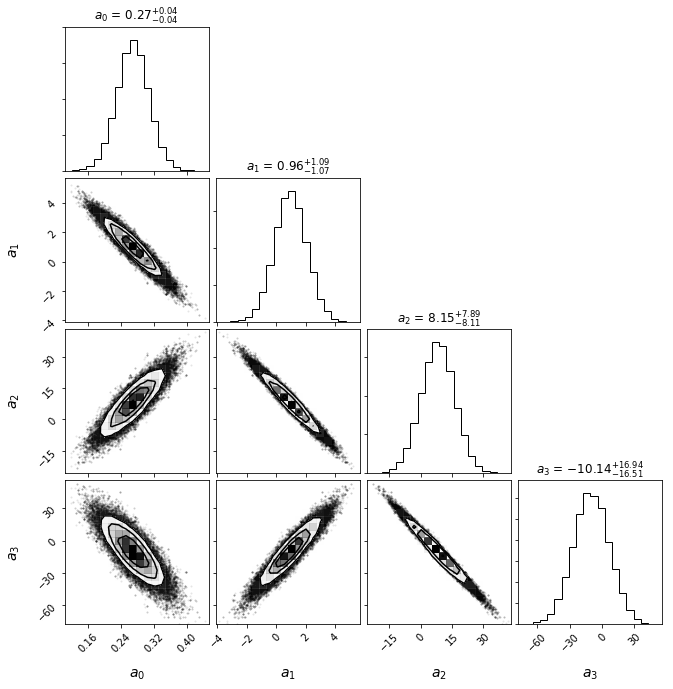

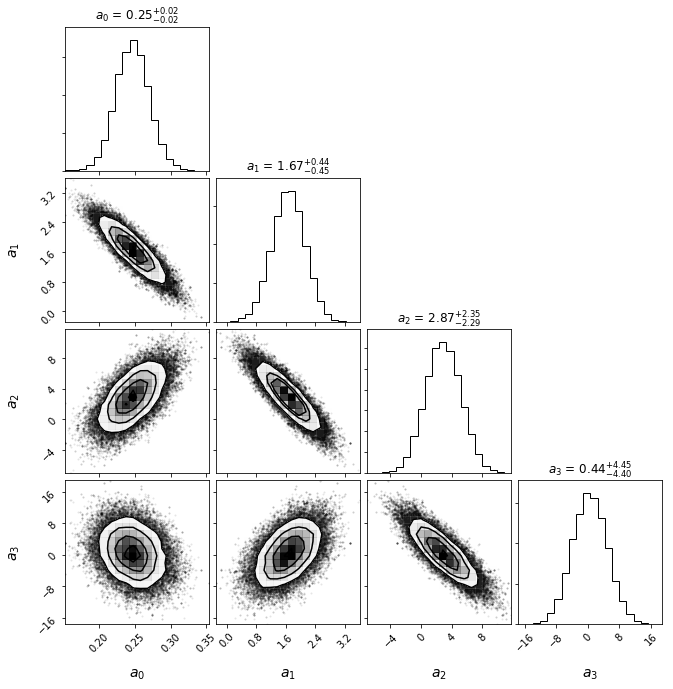

In [201]:
# Plot the marginalized chain using corner. 
fig_uniform = corner.corner(samples_uniform, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
                            label_kwargs={"fontsize":14},
                           show_titles=True, title_kwargs={"fontsize": 12})
fig_uniform.savefig("corner_uniform")

fig_natural = corner.corner(sampler_natural, labels=[r"$a_0$", r"$a_1$", r"$a_2$", r"$a_3$"],
                            label_kwargs={"fontsize":14},
                           show_titles=True, title_kwargs={"fontsize": 12})
fig_natural.savefig("corner_natural")